In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import torch.optim as optim
import numpy as np 
import os 


#### Loading preprocessed data from files

In [3]:
input_paths = ['list_of_all_vec_files']
train_vec = r'train_vec'
test_vec = r'test_vec'
train_files = []
test_files = []

for file in input_paths:
    if train_vec in file:
        train_files.append(file)
    elif test_vec in file:
        test_files.append(file)

In [4]:
def vector_padding(max_length, arr):
        row_length, col_length = arr.shape 
        if row_length > max_length:
            padded = arr[:max_length, :]
        else:
            zero_row_length = max_length - row_length
            padded = torch.cat((arr, torch.zeros(zero_row_length, col_length)))
        return padded

def data_vec_to_pad(max_length, files):
        x_values = []

        for file in files:
            X, y = torch.load(file)
            for i in range(len(X)):
                X[i] = vector_padding(max_length, X[i])
            x_values.append((torch.stack(X), y)) # (8, (tuple of total x, total y))

        return x_values

In [5]:
# maximum length for padding 
max_length = 240
train = data_vec_to_pad(max_length, train_files)
test = data_vec_to_pad(max_length, test_files)

### LSTM Architecture

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, sequence_length, hidden_size, p=.3, num_layer=1):
        super().__init__()
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size 
        self.num_layer = num_layer
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True) # this result in a batch, 300, 500 
        self.norm1 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(p=p)
        self.fc = nn.Linear(sequence_length*hidden_size, 500)
        self.norm2 = nn.LayerNorm(500)
        self.dropout = nn.Dropout(p=p)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
        lstm_res, hidden_weights = self.lstm(x)
        lstm_res = self.norm1(lstm_res)
        lstm_res = self.dropout(lstm_res)
        reshaped_x = lstm_res.reshape(-1, self.sequence_length*self.hidden_size)
        x = F.relu(self.fc(reshaped_x))
        x = self.norm2(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
def accuracy(model, preprocessed):
    'finds batch wise accuracy'
    acc = []
    for (X, y) in preprocessed:
        X = X.cuda()
        y = y.type(torch.LongTensor)   
        y = y.cuda()
        
        with torch.no_grad():
            pred = model(X)
            softmaxed = F.softmax(pred, dim=1)
            result = torch.argmax(softmaxed, dim=1)
            cpu_res = result.to('cpu')
            y = y.to('cpu').numpy()
            numpy_res = cpu_res.numpy()
            acc.append(accuracy_score(y, numpy_res))
#     print('Average acc: ', sum(acc) / len(acc))
    return acc 

### Training and saving the best accuracy test model

In [8]:

train_acc = []
test_acc = []
gen_test_acc = 0
gen_train_acc = 0

criterion = F.cross_entropy
epochs = 60
input_size = 300
hidden_size = 500
sequence_len = 240
model = LSTM(input_size, sequence_len, hidden_size).cuda()
weight_decay = 1e-5
lr = 1e-3

optimizer = optim.Adam(model.parameters(), lr, weight_decay=weight_decay)


for i in range(epochs):
    for (X, y) in train:
        X = X.cuda()
        y = y.type(torch.LongTensor)   
        y = y.cuda()
        
        optimizer.zero_grad()
        forward = model(X)
        loss = criterion(forward, y)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        acc = accuracy(model, test)
        avg_test = (sum(acc)/len(acc))
        
        acc = accuracy(model, train)
        avg_train = sum(acc)/len(acc)
        
        test_acc_max = max(test_acc) if test_acc else 0
        
        if avg_test > test_acc_max:
            print('saving')
            saving_model = torch.jit.script(model)
            saving_model.save('/kaggle/working/without_best_test_acc_model.pt')
            gen_train_acc = avg_train
            gen_test_acc = avg_test
        
        train_acc.append(avg_train)
        test_acc.append(avg_test)
        
        
        
    print('Train:', train_acc[-1], '---------','Test: ', test_acc[-1])

saving
Train: 0.5034022580910149 --------- Test:  0.505808594014533
saving
Train: 0.6578383560058719 --------- Test:  0.6593541344980676
saving
Train: 0.734870765878591 --------- Test:  0.7330046801548035
saving
Train: 0.7949303396852836 --------- Test:  0.7843649733523707
saving
Train: 0.8325003014558597 --------- Test:  0.8046143510376602
saving
Train: 0.8685345317337437 --------- Test:  0.8098235468070595
Train: 0.8767315621589873 --------- Test:  0.8077532739809036
Train: 0.875550553150721 --------- Test:  0.7922052201248239
Train: 0.918005394996807 --------- Test:  0.8037152698530705
Train: 0.9271521805422666 --------- Test:  0.8025428525438867
Train: 0.8823469349315858 --------- Test:  0.7637750563582647
Train: 0.9283031605195294 --------- Test:  0.792059055553399
Train: 0.9584575392214455 --------- Test:  0.8054413942848766
Train: 0.9576853973489589 --------- Test:  0.7959022229234666
Train: 0.974970465667434 --------- Test:  0.8022847115663122
Train: 0.9473517088532355 --------

Test accuracy: 0.8098235468070595 Train accuracy: 0.8685345317337437


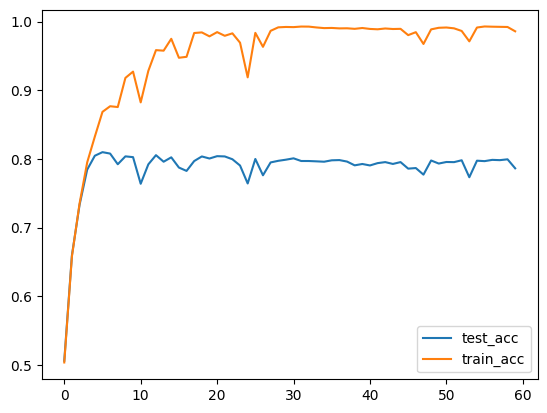

In [9]:
plt.plot(test_acc, label='test_acc')
plt.plot(train_acc, label='train_acc')
plt.legend()
print('Test accuracy:', gen_test_acc, 'Train accuracy:', gen_train_acc)

In [10]:
model = torch.jit.load('saved_model_path')
cpu_jit_model = torch.jit.script(model).cpu()
cpu_jit_model.save('cpu_new_model')